# Sentiment Classification of Movie Reviews using N-Gram Modeling

![sentiment](https://user-images.githubusercontent.com/54467567/74287111-d3596500-4cee-11ea-9344-77ad2d16d04f.jpg)



## Natural Language Processing using Google Colab


Steps
1. NLP text pre-processing
2. Split of training, validation and testing datasets
3. How to build a simple feed-forward neural net classifier using PyTorch 
4. Training the model and the balance of Under-fitting v.s. Over-fitting
5. BoW and TF-IDF text classifier 

In [1]:
! pip install pyprind

In [2]:
!pip install nltk

In [3]:
! pip install tqdm --upgrade

Requirement already up-to-date: tqdm in /usr/local/lib/python3.6/dist-packages (4.42.1)


In [59]:
import tarfile
import os
import pyprind
import pandas as pd
import numpy as np
import re
import nltk
from pathlib import Path
from google_drive_downloader import GoogleDriveDownloader as gdd
from functools import partial
from collections import Counter 
from tqdm import tqdm, tqdm_notebook
nltk.download('punkt')
tqdm.pandas()
########### TOKENIZATIN ############
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.util import ngrams
from nltk.tokenize import wordpunct_tokenize

########### STEMMING ###############
import nltk
from nltk.stem.porter import PorterStemmer
porter = PorterStemmer()

########### STOPWORDS ##############
nltk.download('stopwords')
from nltk.corpus import stopwords

########### LEMMATIZATION ##########
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
nltk.download('wordnet')

########### LDA ####################
from sklearn.decomposition import LatentDirichletAllocation

########### TEST & TRAIN SPLIT #####
from sklearn.model_selection import train_test_split

########### LOGISTIC REGRESSION #####
from sklearn.linear_model import LogisticRegression

########## PYTORCH ##################
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split

########## PLOT ####################
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from IPython.core.display import display, HTML

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


device(type='cuda')

### File Loading

In [0]:
# Downloading the file from GoogleDrive
DATA_PATH = 'data/imdb_reviews.csv'
if not Path(DATA_PATH).is_file():
    gdd.download_file_from_google_drive(
        file_id='1zfM5E6HvKIe7f3rEt1V2gBpw5QOSSKQz',
        dest_path=DATA_PATH,
    )

In [8]:
df = pd.read_csv(DATA_PATH)
df.sample(5)

,review,label
60182,"I really can't remember who recommended this, ...",1
9090,"This is one of the worst films i've ever seen,...",0
32956,Well. this was not a surprise. many people wil...,0
49196,Deeply emotional. It can't leave you neutral.<...,1
60092,Greetings again from the darkness. What ever h...,0


In [9]:
# Shuffling & re-indexing the data
np.random.seed(0)
df = df.reindex(np.random.permutation(df.index))
print(df.shape)

(62155, 2)


# Process of performing sentiment analysis :
![model](https://user-images.githubusercontent.com/54467567/68970713-89271d00-07ad-11ea-87d2-e5d55344a31c.PNG)

reference : https://www.datacamp.com/community/tutorials/text-analytics-beginners-nltk

**Text Characteristics**

In [10]:
print('Number of records:', len(df), '\n')
print('Number of positive reviews:', len(df[df.label == 1]))
print('Number of negative reviews:', len(df[df.label == 0]), '\n')

print('Example negative review:')
print(df.loc[55,].review, '\n')
print('Example positive review:')
print(df.loc[12361,].review, '\n')

Number of records: 62155 

Number of positive reviews: 30870
Number of negative reviews: 31285 

Example negative review:
Seeing this film for the first time twenty years after its release I don't quite get it. Why has this been such a huge hit in 1986? Its amateurishness drips from every scene. The jokes are lame and predictable. The sex scenes are exploitative and over the top (that is not to say that Miss Rudnik does not have nice boobs!). The singing is "schrecklich". The only genuinely funny scene is the big shoot out when the gangsters die break dancing, a trait that dates the movie firmly to the mid-eighties. It's really quite puzzling to me how incapable I am to grasp what evoked the enthusiasm of the cheering audiences in 1986 (and apparently still today, reading my fellow IMDBers comments). 

Example positive review:
I went and saw this movie last night after being coaxed to by a few friends of mine. I'll admit that I was reluctant to see it because from what I knew of Ashton

## Preprocess Text

* Replace weird characters
* Lowercase
* Tokenize 
* Stemming & Lemmatize
* Remove stopwords
* Build index

In [0]:
def remove_rare_words(tokens, common_tokens, max_len):
    return [token if token in common_tokens else '<UNK>' for token in tokens][-max_len:]

def replace_numbers(tokens):
    return [re.sub(r'[0-9]+', '<NUM>', token) for token in tokens]

def tokenize(text, stop_words, lemmatizer):
    text = re.sub(r'[^\w\s]', '', text) # remove special characters
    text = text.lower() # lowercase
    tokens = wordpunct_tokenize(text) # tokenize
    tokens = [lemmatizer.lemmatize(token) for token in tokens] # noun lemmatizer
    tokens = [lemmatizer.lemmatize(token, "v") for token in tokens] # verb lemmatizer
    tokens = [token for token in tokens if token not in stop_words] # remove stopwords
    return tokens

def build_bow_vector(sequence, idx2token):
    vector = [0] * len(idx2token)
    for token_idx in sequence:
        if token_idx not in idx2token:
            raise ValueError('Wrong sequence index found!')
        else:
            vector[token_idx] += 1
    return vector

In [0]:
# Set parameters

MAX_LEN = 128 #@param [64, 256, 512, 1024] {allow-input: true}
#the maximum of words per review
MAX_VOCAB = 1000 #@param [1000, 5000, 10000, 100000] {allow-input: true} 

In [0]:
class ImdbDataset(Dataset):
    def __init__(self, data_path, max_vocab=5000, max_len=128):
        df = pd.read_csv(data_path)
        
        print(df.shape)
        # Clean and tokenize
        stop_words = set(stopwords.words('english'))
        lemmatizer = WordNetLemmatizer()
        df['tokens'] = df.review.apply(
            partial(
                tokenize,
                stop_words=stop_words,
                lemmatizer=lemmatizer
            ),
        )  
        
        all_tokens = [token for doc in list(df.tokens) for token in doc]
        
        # Build most common tokens bound by max vocab size
        common_tokens = set( 
            list(
                zip(*Counter(all_tokens).most_common(max_vocab))
            )[0] 
        )

        # Replace rare words with <UNK>
        df.loc[:, 'tokens'] = df.tokens.progress_apply(
            partial(
                remove_rare_words,
                common_tokens=common_tokens,
                max_len=max_len,
            ),
        )
        
        # Replace numbers with <NUM>
        df.loc[:, 'tokens'] = df.tokens.progress_apply(replace_numbers)
        
        # Remove sequences with only <UNK>
        df = df[df.tokens.progress_apply(
            lambda tokens: any(token != '<UNK>' for token in tokens),
        )]
        
        # Build vocab
        vocab = sorted(set(
            token for doc in list(df.tokens) for token in doc
        ))
        self.token2idx = {token: idx for idx, token in enumerate(vocab)}
        self.idx2token = {idx: token for token, idx in self.token2idx.items()}
        
        # Convert tokens to indexes
        df['indexed_tokens'] = df.tokens.progress_apply(
            lambda doc: [self.token2idx[token] for token in doc],
        )
        
        # Build BoW vector
        df['bow_vector'] = df.indexed_tokens.progress_apply(
            build_bow_vector, args=(self.idx2token,)
        )
        
        # Build TF-IDF vector
        vectorizer = TfidfVectorizer(
            analyzer='word',
            tokenizer=lambda doc: doc,
            preprocessor=lambda doc: doc,
            token_pattern=None,
        )
        vectors = vectorizer.fit_transform(df.tokens).toarray()
        df['tfidf_vector'] = [vector.tolist() for vector in vectors]
        
        self.text = df.review.tolist()
        self.sequences = df.indexed_tokens.tolist()
        self.bow_vector = df.bow_vector.tolist()
        self.tfidf_vector = df.tfidf_vector.tolist()
        self.targets = df.label.tolist()
    
    def __getitem__(self, i):
        return (
            self.sequences[i],
            self.bow_vector[i],
            self.tfidf_vector[i],
            self.targets[i],
            self.text[i],
        )
    
    def __len__(self):
        return len(self.targets)

In [23]:
dataset = ImdbDataset(DATA_PATH, max_vocab=MAX_VOCAB, max_len=MAX_LEN )

(62155, 2)


100%|██████████| 62154/62154 [00:02<00:00, 26939.61it/s]


**A sample of processed text**

In [25]:
print('Number of records:', len(dataset), '\n')

import random
random_idx = random.randint(0,len(dataset)-1)
print('index:', random_idx, '\n')
sample_seq, bow_vector, tfidf_vector, sample_target, sample_text = dataset[random_idx]
print(sample_text, '\n')
print(sample_seq, '\n')
print('BoW vector size:', len(bow_vector), '\n')
print('TF-IDF vector size:', len(tfidf_vector), '\n')
print('Sentiment:', sample_target, '\n')

Number of records: 62154 

index: 42463 

This movie makes me want to fall in love all over again!I am naming my next daughter "Adelaide". Just so that someone who sings like Ol Blue eyes can swoon her one day, and feel the butterflies I felt hearing it sung, and it wasn't even to me! I give it a 9/10 

[561, 521, 936, 319, 516, 1, 570, 578, 209, 1, 789, 776, 504, 1, 101, 313, 1, 599, 211, 332, 1, 333, 408, 776, 939, 294, 382, 1] 

BoW vector size: 990 

TF-IDF vector size: 990 

Sentiment: 1 



**Tokenization**


Tokenization is the process by which big quantity of text is divided into smaller parts called tokens.
Natural language processing is used for building applications such as Text classification, intelligent chatbot,
sentimental analysis, language translation, etc. It becomes vital to understand the pattern in the text to achieve
the above-stated purpose. These tokens are very useful for finding such patterns as well as is considered as a 
base step for stemming and lemmatization.


**Stemming**

Stemming algorithms work by cutting off the end or the beginning of the word, taking into account a list of common prefixes and suffixes that can be found in an inflected word. This indiscriminate cutting can be successful in some occasions, but not always, and that is why we affirm that this approach presents some limitations. Below we illustrate the method with examples in both English and Spanish (It requires knowledge of suffix and prefix)

![stemming](https://user-images.githubusercontent.com/54467567/68964605-6aba2500-079f-11ea-9144-6e4c5b43cc79.PNG)

reference : https://blog.bitext.com/what-is-the-difference-between-stemming-and-lemmatization/

**Lemmatization**

Lemmatization, on the other hand, takes into consideration the morphological analysis of the words. To do so, it is necessary to have detailed dictionaries which the algorithm can look through to link the form back to its lemma. See how it works with the same example words.(It requires the complete dictionary of the language)
![lemma](https://user-images.githubusercontent.com/54467567/68964888-13688480-07a0-11ea-8745-578d07bd186f.PNG)

reference : https://blog.bitext.com/what-is-the-difference-between-stemming-and-lemmatization/

**TF-IDF**

Term-Frequency and Inverse Document Frequency is the process of creating numeric values for each of the text terms and assigning proper weigts as per the relevance of the word in the documents. It is calculated as
  

$$\text{tf-idf}(t,d)=\text{tf (t,d)}\times \text{idf}(t,d)$$


where $$\text{tf (t,d)}$$ is frequency distribution of each word in the document. it creates a sparse vector with the index of the word and frequency/count of the word

# Spliting into training & validation

In [0]:
def split_train_valid_test(corpus, valid_ratio=0.1, test_ratio=0.1):
    """Split dataset into train, validation, and test."""
    test_length = int(len(corpus) * test_ratio)
    valid_length = int(len(corpus) * valid_ratio)
    train_length = len(corpus) - valid_length - test_length
    return random_split(
        corpus, lengths=[train_length, valid_length, test_length],
    )

In [29]:
train_dataset, valid_dataset, test_dataset = split_train_valid_test(
    dataset, valid_ratio=0.05, test_ratio=0.05)
len(train_dataset), len(valid_dataset), len(test_dataset)

(55940, 3107, 3107)

In [0]:
#creating PyTorch tensor for train,test & validate
#based on the batch size
BATCH_SIZE = 528

def collate(batch):
    seq = [item[0] for item in batch]
    bow = [item[1] for item in batch]
    tfidf = [item[2] for item in batch]
    target = torch.LongTensor([item[3] for item in batch])
    text = [item[4] for item in batch]
    return seq, bow, tfidf, target, text

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, collate_fn=collate)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate)

# BAG OF WORD MODEL USING PYTORCH
![pytorch](https://user-images.githubusercontent.com/54467567/74287177-f4ba5100-4cee-11ea-9505-f79f3c528225.png)


NEURAL NETWORK MODEL

Layer 1 affine: $$x_1 = W_1 X + b_1$$
Layer 1 activation: $$h_1 = Relu(x_1)$$
Layer 2 affine: $$x_2 = W_2 h_1 + b_2$$
output: $$p = softmax(x_2)$$
Loss: $$L = −(ylog(p)+(1−y)log(1−p))$$
Gradient: 
$$\frac{\partial }{\partial W_1}L(W_1, b_1, W_2, b_2) = \frac{\partial L}{\partial p}\frac{\partial p}{\partial x_2}\frac{\partial x_2}{\partial h_1}\frac{\partial h_1}{\partial x_1}\frac{\partial x_1}{\partial W_1}$$

Parameter update:
$$W_1 = W_1 - \alpha \frac{\partial L}{\partial W_1}$$

In [0]:
class FeedfowardTextClassifier(nn.Module):
    def __init__(self, device, vocab_size, hidden1, hidden2, num_labels, batch_size):
        super(FeedfowardTextClassifier, self).__init__()
        self.device = device
        self.batch_size = batch_size
        self.fc1 = nn.Linear(vocab_size, hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.fc3 = nn.Linear(hidden2, num_labels)
    
    def forward(self, x):
        batch_size = len(x)
        if batch_size != self.batch_size:
            self.batch_size = batch_size
        x = torch.FloatTensor(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return torch.sigmoid(self.fc3(x))


In [0]:
# Define hidden layer size
HIDDEN1 = 100 #@param [10, 30, 50, 100, 200, 500] {allow-input: true}
HIDDEN2 = 50 #@param [10, 30, 50, 100, 200, 500] {allow-input: true}

In [39]:
# Defining Bag of Word Model
bow_model = FeedfowardTextClassifier(
    vocab_size=len(dataset.token2idx),
    hidden1=HIDDEN1,
    hidden2=HIDDEN2,
    num_labels=2,
    device=device,
    batch_size=BATCH_SIZE,
)
bow_model

FeedfowardTextClassifier(
  (fc1): Linear(in_features=990, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=2, bias=True)
)

# Creating Training Loop

In [0]:
# Defining loss
LEARNING_RATE = 5e-4
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, bow_model.parameters()),
    lr=LEARNING_RATE,
)
scheduler = CosineAnnealingLR(optimizer, 1)

In [0]:
def train_epoch(model, optimizer, train_loader, input_type='bow'):
    model.train()
    total_loss, total = 0, 0
    for seq, bow, tfidf, target, text in train_loader:
        if input_type == 'bow':
            inputs = bow
        if input_type == 'tfidf':
            inputs = tfidf
        
        # Reset gradient
        optimizer.zero_grad()
        
        # Forward pass
        output = model(inputs)
        
        # Compute loss
        loss = criterion(output, target)
        
        # Perform gradient descent, backwards pass
        loss.backward()

        # Take a step in the right direction
        optimizer.step()
        scheduler.step()

        # Record metrics
        total_loss += loss.item()
        total += len(target)

    return total_loss / total


def validate_epoch(model, valid_loader, input_type='bow'):
    model.eval()
    total_loss, total = 0, 0
    with torch.no_grad():
        for seq, bow, tfidf, target, text in valid_loader:
            if input_type == 'bow':
                inputs = bow
            if input_type == 'tfidf':
                inputs = tfidf

            # Forward pass
            output = model(inputs)

            # Calculate how wrong the model is
            loss = criterion(output, target)

            # Record metrics
            total_loss += loss.item()
            total += len(target)

    return total_loss / total

In [44]:
# Checking the performance of BOW with early stop criteria for validation loss
n_epochs = 0
train_losses, valid_losses = [], []
while True:
    train_loss = train_epoch(bow_model, optimizer, train_loader, input_type='bow')
    valid_loss = validate_epoch(bow_model, valid_loader, input_type='bow')
    
    tqdm.write(
        f'epoch #{n_epochs + 1:3d}\ttrain_loss: {train_loss:.2e}\tvalid_loss: {valid_loss:.2e}\n',
    )
    
    # Early stopping if the current valid_loss is greater than the last three valid losses
    if len(valid_losses) > 2 and all(valid_loss >= loss for loss in valid_losses[-3:]):
        print('Stopping early')
        break
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    n_epochs += 1

epoch #  1	train_loss: 1.21e-03	valid_loss: 1.04e-03

epoch #  2	train_loss: 9.27e-04	valid_loss: 9.09e-04

epoch #  3	train_loss: 8.68e-04	valid_loss: 8.87e-04

epoch #  4	train_loss: 8.51e-04	valid_loss: 8.81e-04

epoch #  5	train_loss: 8.43e-04	valid_loss: 8.78e-04

epoch #  6	train_loss: 8.37e-04	valid_loss: 8.77e-04

epoch #  7	train_loss: 8.33e-04	valid_loss: 8.77e-04

epoch #  8	train_loss: 8.29e-04	valid_loss: 8.78e-04

epoch #  9	train_loss: 8.25e-04	valid_loss: 8.78e-04

Stopping early


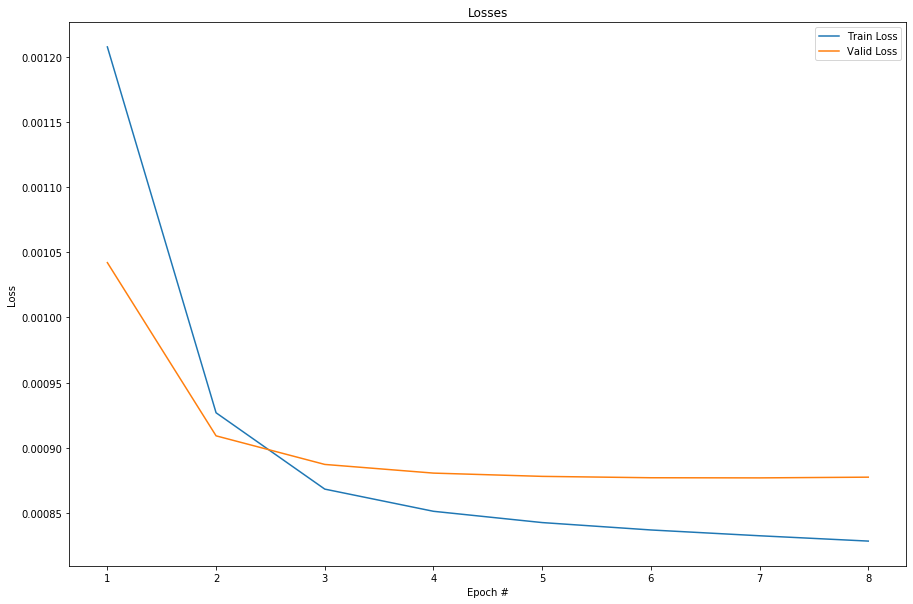

In [52]:
# Plotting the performance of the BOW model
epoch_ticks = range(1, n_epochs + 1)
plt.figure(figsize=(15,10))
plt.plot(epoch_ticks, train_losses)
plt.plot(epoch_ticks, valid_losses)
plt.legend(['Train Loss', 'Valid Loss'])
plt.title('Losses') 
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.xticks(epoch_ticks)
plt.show()

In [55]:
# Checking metrics
bow_model.eval()
test_accuracy, n_examples = 0, 0
y_true, y_pred = [], []
input_type = 'bow'

with torch.no_grad():
    for seq, bow, tfidf, target, text in test_loader:
        inputs = bow
        probs = bow_model(inputs)
        if input_type == 'tdidf':
            inputs = tfidf
            probs = tfidf_model(inputs)
        
        probs = probs.detach().cpu().numpy()
        predictions = np.argmax(probs, axis=1)
        target = target.cpu().numpy()
        
        y_true.extend(predictions)
        y_pred.extend(target)
        
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.84      0.86      1639
           1       0.83      0.87      0.85      1468

    accuracy                           0.86      3107
   macro avg       0.86      0.86      0.86      3107
weighted avg       0.86      0.86      0.86      3107



# Example of the Prediction

In [0]:
flatten = lambda x: [sublst for lst in x for sublst in lst]
seq_lst, bow_lst, tfidf_lst, target_lst, text_lst = zip(*test_loader)
seq_lst, bow_lst, tfidf_lst, target_lst, text_lst = map(flatten, [seq_lst, bow_lst, tfidf_lst, target_lst, text_lst])
test_examples = list(zip(seq_lst, bow_lst, tfidf_lst, target_lst, text_lst))

def print_random_prediction(model, n=5, input_type='bow'):
    to_emoji = lambda x: '😄' if x else '😡'
    model.eval()
    rows = []
    for i in range(n):
        with torch.no_grad():
            seq, bow, tdidf, target, text = random.choice(test_examples)
            target = target.item()
            
            inputs = bow
            if input_type == 'tdidf':
                inputs = tfidf

            probs = model([inputs])
            probs = probs.detach().cpu().numpy()
            prediction = np.argmax(probs, axis=1)[0]

            predicted = to_emoji(prediction)
            actual = to_emoji(target)
            
            row = f"""
            <tr>
            <td>{i+1}&nbsp;</td>
            <td>{text}&nbsp;</td>
            <td>{predicted}&nbsp;</td>
            <td>{actual}&nbsp;</td>
            </tr>
            """
            rows.append(row)
            
    rows_joined = '\n'.join(rows)
    table = f"""
    <table>
    <tbody>
    <tr>
    <td><b>Number</b>&nbsp;</td>
    <td><b>Review</b>&nbsp;</td>
    <td><b>Predicted</b>&nbsp;</td>
    <td><b>Actual</b>&nbsp;</td>
    </tr>{rows_joined}
    </tbody>
    </table>
    """
    display(HTML(table))

In [61]:
print_random_prediction(bow_model, n=5, input_type='bow')

Number,Review,Predicted,Actual
1,"The movie Angels of the Universe is a pure masterpiece and it proves once again that you can make a brilliant movie on a low budget, e.g American Beauty and Blair Witch Project. The Director Fridrik ThÃ³r Fridriksson gives the novel Englar alheimsins a new life on the white screen. The movie is a breakthrough in Icelandic film making because it's the biggest and the greatest movie that has been done in Iceland.The music in the film, played by SigurrÃ³s, is very symbolic for the film, it is absolutely brilliant. I recommend everybody who are able to think to go and see this film as soon as possible, you won't be disappointed. I would bet on this film to win the best foreign film award next year Â? all over the globe!",😄,😄
2,"This movie is really bad. The hero can't play. You see too much that he learned his walking moves by heart. And believe me, he walks a lot. For 45 min, nothing happens. He only walks to places and gets out..... Like if the story was so short that they had to extend it by adding useless and boring ""looks-like-a-suspens"" scenes.Dialogues are very poor. I counted around a lots of ""hello's"" and few ""hang on"" on the 1st part.Blood is orange like the Mercurochrome you put on kid's blisters. And scenes are not following themselves. A bloody neck on a scene, a clean neck on the following.The story could have been improved. Yeah I mean what the hell is the story? Martial arts? Where? Is that martial arts? Watch how hesitant and slow are the moves!!!!! If giving a kick and receiving a punch is called martial arts, then I am Bruce Lee!!!!The only good point I have found is on fight scenes : They don't play with zoom and fast switching scenes that gives you headache in most of action movies.There are plenty of low budget movies that are great. That one was just to make money. Nothing else.",😡,😡
3,"This movie isn't worth the film it was photographed on. The dialog is flat, filled with clichÃ© overused lines and delivered by amateur actors who sound like their reading a script for the first time. The choppy, shaky, film style is a cheap imitation of the ""The Ring"" style visual effects. The characters do not even act like a normal person would. For example, the character who is looking for her twin sister at her home forces her way through the front door, creeps around the house all frightened and sobbing and she doesn't even once call out her sister's name to see if she is home. What? You would think she had just buried her sister instead of searching for her. Way too many flashbacks to her childhood. Too many unnecessary flashbacks is a typical sign of an amateur director. It is actually funny watching the numerous shots of the woman driving her car down the street, up the driveway, around this corner, over here, over there, oh a side view, now a front view. Enough already. You would think you are watching a TV commercial for the Solaris! Terrible movie. 0 out of 100. I really pity anybody who spent money making this film or to watch it.",😡,😡
4,"Based on a Ray Bradbury story; a professional photographer(Brian Kerwin)returns to his modest home near a tiny desert town, where most of the citizens wishes he stayed away. A lonely boy(Jonathan Carrasco) latches onto him for the attention; and the two witness the landing of an alien craft in the rocky region of the desert. The aliens turn themselves into the images of townspeople. Kerwin must convince evacuation of the town and falls in love with the young boy's mother(Elizabeth Pena). Acting is pretty shallow; the story line is no worse than some others; this movie leaves you feeling that you got shorted on a decent ending. Supporting cast includes: Howard Morris, Dean Norris and Mickey Jones.",😡,😡
5,"Imaginative, quick-paced, satirical! Americans do 'zany', but the Brits do 'witty' -- and they love to poke fun at themselves (ahem: unattractive teeth, large lips/nose, 'veddy' common or 'veddy' snobby, obsession with the 'gahden'). Ins